<a href="https://colab.research.google.com/github/Alinka7/-NUMERICAL-SOLUTION-OF-DIFFERENTIAL-EQUATIONS-IN-PARTIAL-DERIVATIVES-/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Untitled6_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [4]:
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [5]:
framObjTrain = LoadData( framObjTrain,
                        imgPath = '/content/drive/MyDrive/Colab Notebooks/CamVid/train', 
                        maskPath = '/content/drive/MyDrive/Colab Notebooks/CamVid/train_labels'
         , shape = 256)

In [6]:
framObjValidation  = LoadData( framObjValidation,
                              imgPath = '/content/drive/MyDrive/Colab Notebooks/CamVid/val',
                              maskPath = '/content/drive/MyDrive/Colab Notebooks/CamVid/val_labels'
         , shape = 256)

In [7]:
framObjTrain['img'][1].shape

(256, 256, 3)

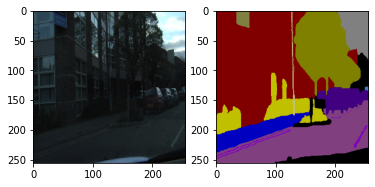

In [8]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [9]:
t = tf.convert_to_tensor(framObjTrain['img'])
t*=255
train = tf.dtypes.cast(t, tf.uint8)


t1 = tf.convert_to_tensor(framObjValidation['img'])
t1*=255
test = tf.dtypes.cast(t1, tf.uint8)

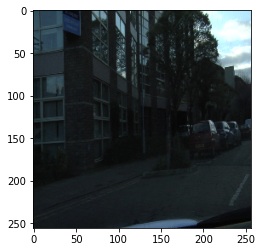

In [10]:
plt.imshow(train[1])


In [11]:

@tf.function
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data / 255,(128,128,3)),tf.float32)

  lr=tf.image.resize(cropped,(64,64))
  lr=tf.image.resize(lr,(128,128), method = tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)
def downsample_image(image,scale):
  lr=tf.image.resize(image / 255,(image.shape[0]//scale, image.shape[1]//scale))
  lr=tf.image.resize(lr,(image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
  return lr

In [12]:
train_dataset_mapped =  tf.data.Dataset.from_tensor_slices(train).map(build_data, num_parallel_calls = tf.data.AUTOTUNE)

In [13]:
test_dataset_mapped =  tf.data.Dataset.from_tensor_slices(test).map(build_data, num_parallel_calls = tf.data.AUTOTUNE)

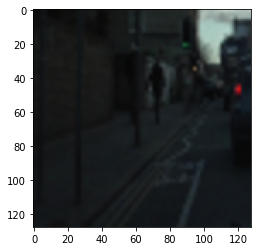

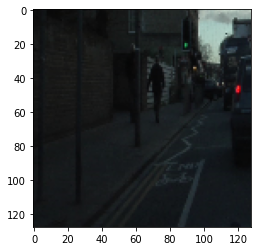

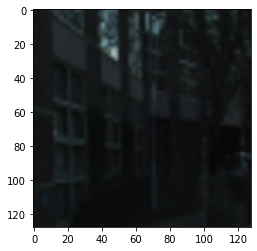

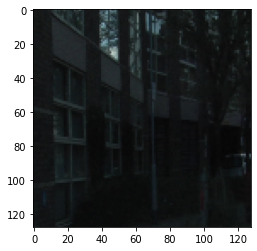

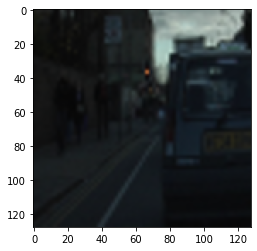

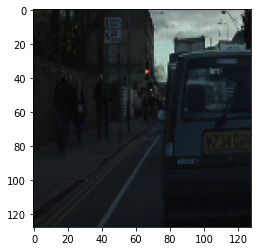

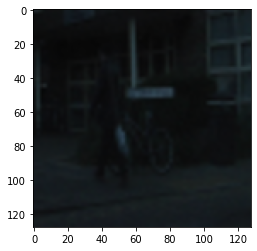

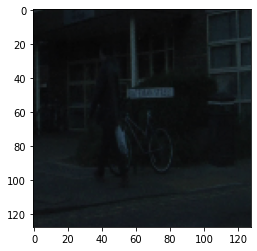

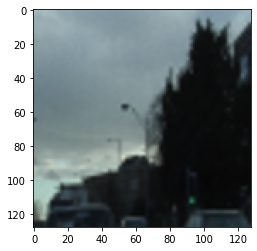

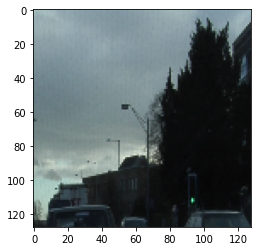

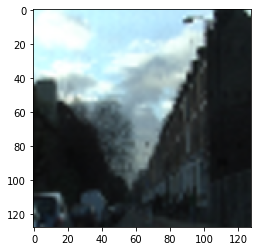

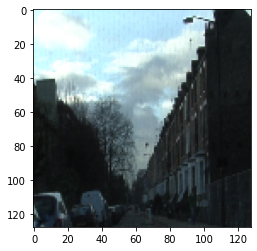

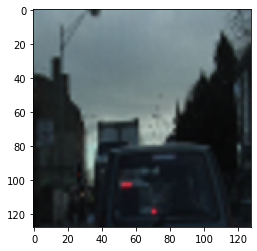

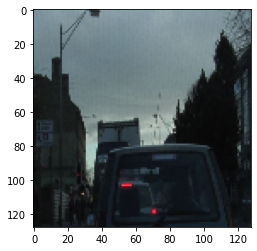

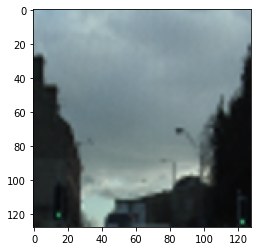

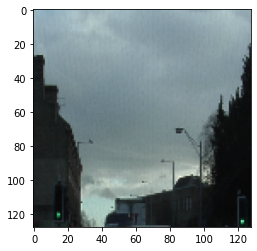

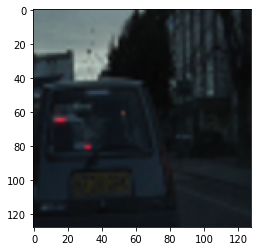

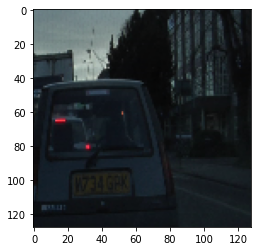

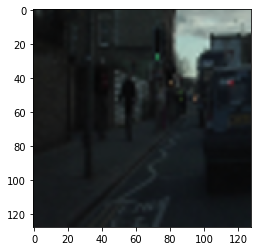

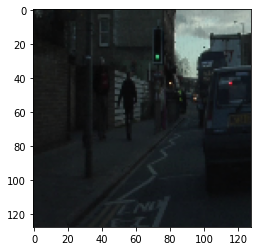

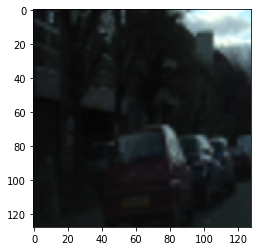

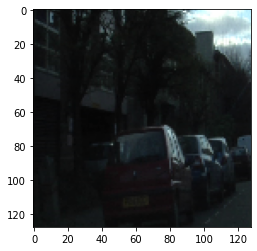

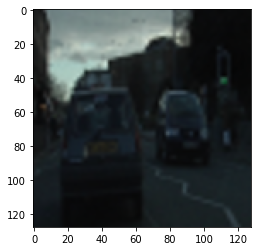

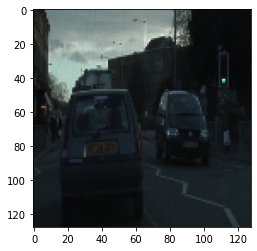

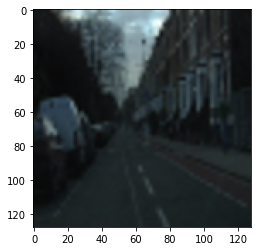

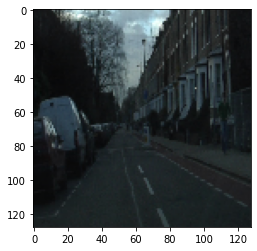

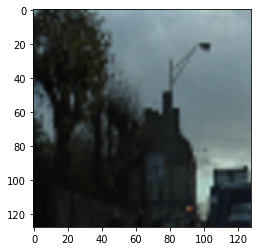

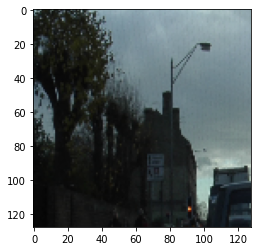

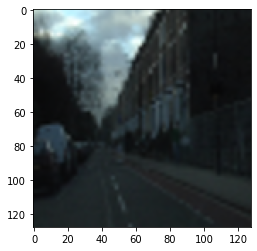

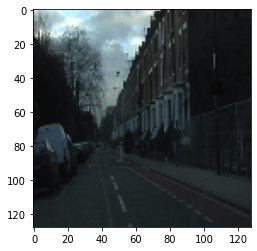

In [14]:
for x in train_dataset_mapped.take(15):
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

In [15]:
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )
# def PSNR(y_true,y_pred):
#   mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
#   return 20 * log10(1 / (mse ** 0.5))

# def log10(x):
#   numerator = tf.log(x)
#   denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
#   return numerator / denominator
SRCNN_915.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

In [16]:
for x in range(50):
  train_dataset_mapped = tf.data.Dataset.from_tensor_slices(train).map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
  val_dataset_mapped = tf.data.Dataset.from_tensor_slices(test).map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
  
  SRCNN_915.fit(train_dataset_mapped,epochs=1,validation_data=val_dataset_mapped)

3/3 [==============================] - 85s 29s/step - loss: 0.0070 - val_loss: 0.0063


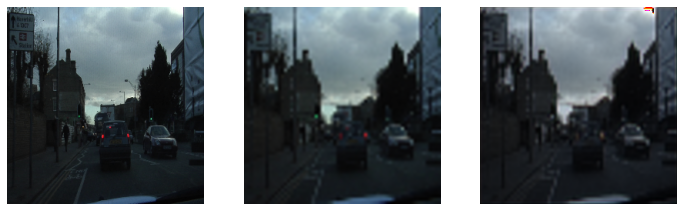

In [17]:
train_dataset_mapped = tf.data.Dataset.from_tensor_slices(train).map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in tf.data.Dataset.from_tensor_slices(train).take(1):
  fig=plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(x.numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  lr=downsample_image(x.numpy(),4)
  plt.imshow(lr.numpy())  
  plt.axis('off')
  plt.subplot(1,3,3)
  pred=SRCNN_915(np.array([lr]))
  plt.imshow(tf.dtypes.cast(pred[0]*255, tf.uint8).numpy())
  # print(tf.dtypes.cast(pred[0]*255, tf.uint8).numpy().min())
  plt.axis('off')
  plt.show()